In [19]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline

In [2]:
dowStocks = pd.read_csv(Path('../data/external/dow_jones_index.data'))
dowStocks['date'] = pd.to_datetime(dowStocks['date'])
dowStocks.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,2011-01-07,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,2011-01-14,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,2011-01-21,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,2011-01-28,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2011-02-04,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [3]:
dowStocks.dtypes

quarter                                        int64
stock                                         object
date                                  datetime64[ns]
open                                          object
high                                          object
low                                           object
close                                         object
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                               object
next_weeks_close                              object
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object

 
 Note: next_weeks_open and next_weeks_close are sources of data leakage.


In [4]:
def stripDollars(df: pd.DataFrame)-> pd.DataFrame:
    """
    Strips out dollar signs and converts to float64
    :param df: full dataframe with prices as object/str and dollar signs
    :return df: full dataframe without dollar signs and text converted to float for prices. 
    """
    columns = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']
    df[columns] = df[columns].replace(r'[$]', '', regex=True).astype('float64')
    return df

In [5]:
dowStocks = stripDollars(dowStocks)
dowStocks.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
1,1,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,AA,2011-01-21,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029


In [6]:
dowStocks.dtypes

quarter                                        int64
stock                                         object
date                                  datetime64[ns]
open                                         float64
high                                         float64
low                                          float64
close                                        float64
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                              float64
next_weeks_close                             float64
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object

In [7]:
print('Stocks in DOWJONES')
for stock in dowStocks['stock'].unique():
    print(f'{stock}')


Stocks in DOWJONES
AA
AXP
BA
BAC
CAT
CSCO
CVX
DD
DIS
GE
HD
HPQ
IBM
INTC
JNJ
JPM
KRFT
KO
MCD
MMM
MRK
MSFT
PFE
PG
T
TRV
UTX
VZ
WMT
XOM


In [8]:
print('Dates in dataset:')
print(f'Start date: {dowStocks["date"].min()}')
print(f'End date: {dowStocks["date"].max()}')

Dates in dataset:
Start date: 2011-01-07 00:00:00
End date: 2011-06-24 00:00:00


Note: Original dataset recommends using Q1 as train and Q2 as test


In [9]:
dowStocks[dowStocks['stock'] == 'AA'][['date', 'close']].set_index(['date'])

,close
date,
2011-01-07,16.42
2011-01-14,15.97
2011-01-21,15.79
2011-01-28,16.13
2011-02-04,17.14
2011-02-11,17.37
2011-02-18,17.28
2011-02-25,16.68
2011-03-04,16.58


In [10]:
dowStocks.dtypes

quarter                                        int64
stock                                         object
date                                  datetime64[ns]
open                                         float64
high                                         float64
low                                          float64
close                                        float64
volume                                         int64
percent_change_price                         float64
percent_change_volume_over_last_wk           float64
previous_weeks_volume                        float64
next_weeks_open                              float64
next_weeks_close                             float64
percent_change_next_weeks_price              float64
days_to_next_dividend                          int64
percent_return_next_dividend                 float64
dtype: object

In [11]:
dowClose = dowStocks[['stock', 'date', 'close']]

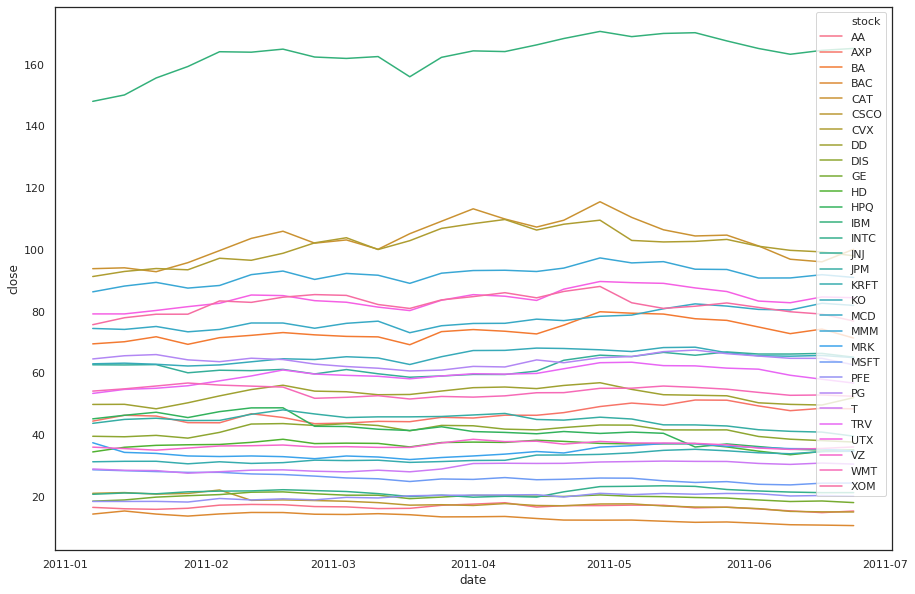

In [12]:
plt.figure(figsize = (15,10))
ax = sns.lineplot(x='date', y="close", data=dowClose, hue = 'stock')
plt.show()

In [13]:
dowClose = dowClose.pivot(index = 'date', columns = 'stock', values = 'close')
dowClose.columns

Index(['AA', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD',
       'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'KRFT', 'MCD', 'MMM', 'MRK',
       'MSFT', 'PFE', 'PG', 'T', 'TRV', 'UTX', 'VZ', 'WMT', 'XOM'],
      dtype='object', name='stock')

In [14]:
def z_scored(df):
    for column in df.columns:
        df[column] = (df[column] - df[column].mean())/ df[column].std()
    return df

In [15]:
dowClose_z = z_scored(dowClose)


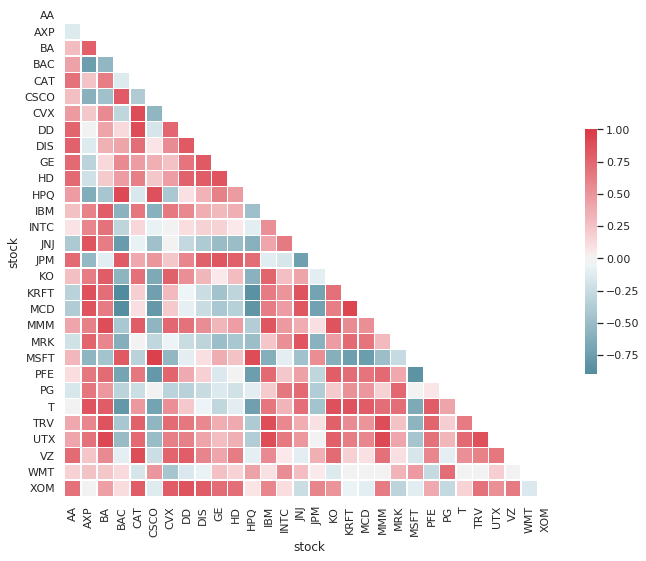

In [16]:
dowClose_corr = dowClose.corr()
mask = np.triu(np.ones_like(dowClose_corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(dowClose_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

MCD and MSFT are negatively correlated



In [17]:
dowClose_selected = dowClose[['MSFT', 'MCD']]
zDowClose = dowClose_z[['MSFT', 'MCD']]

[Text(1, 0, '2011-01-07'),
 Text(1, 0, '2011-01-21'),
 Text(1, 0, '2011-02-04'),
 Text(1, 0, '2011-02-18'),
 Text(1, 0, '2011-03-04'),
 Text(1, 0, '2011-03-18'),
 Text(1, 0, '2011-04-01'),
 Text(1, 0, '2011-04-15'),
 Text(1, 0, '2011-04-29'),
 Text(1, 0, '2011-05-13')]

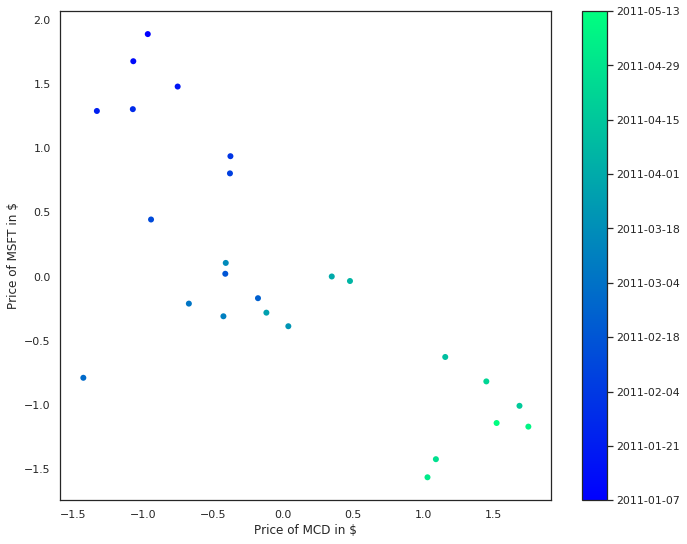

In [18]:
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, xlabel = 'Price of MCD in \$', ylabel = 'Price of MSFT in \$')
colors = np.linspace(0.1, 1, len(dowClose_selected))
cmap = plt.get_cmap('winter')
sc = ax.scatter(dowClose_selected['MCD'], dowClose_selected['MSFT'], c=colors, cmap = cmap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in dowClose_selected[::len(dowClose_selected)//10].index])


Build a naive model

In [19]:
with pm.Model() as naive_model:
    pm.glm.GLM.from_formula('MSFT ~ MCD', dowClose_selected)
    trace_reg = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, MCD, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:33<00:00, 1321.34draws/s]


In [20]:
pm.summary(trace_reg)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.145,-0.273,0.273,0.001,0.001,43535.0,18427.0,43969.0,28284.0,1.0
MCD,-0.755,0.148,-1.038,-0.480,0.001,0.001,43757.0,42405.0,43970.0,29561.0,1.0
sd,0.708,0.113,0.519,0.924,0.001,0.000,33413.0,32673.0,33454.0,24803.0,1.0


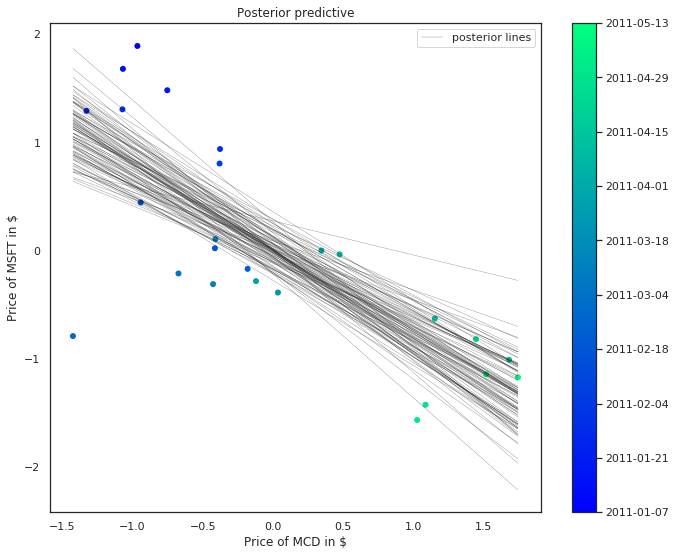

In [21]:
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, xlabel = 'Price of MCD in \$', ylabel = 'Price of MSFT in \$', 
                     title = 'Posterior regression line')
sc = ax.scatter(dowClose_selected['MCD'], dowClose_selected['MSFT'], c=colors, cmap = cmap, lw=0)
pm.plot_posterior_predictive_glm(trace_reg[100:], samples = 100, label = 'posterior lines', 
                                 lm = lambda x, sample: sample['Intercept'] + sample['MCD'] * x, 
                                 eval = np.linspace(dowClose_selected['MCD'].min(), 
                                                    dowClose_selected['MCD'].max(), 100)
                                                    )
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in dowClose_selected[::len(dowClose_selected)//10].index])
ax.legend(loc = 0)

In [35]:
with pm.Model() as randomWalkModel:
    
    sigma_alpha = pm.Exponential('sigma_alpha', 0.5)
    sigma_beta = pm.Exponential('sigma_beta', 0.5) # Bonking here need to investigate more on exp
    
    alpha = pm.GaussianRandomWalk('alpha', sd = sigma_alpha, shape=len(dowClose_selected))
    beta = pm.GaussianRandomWalk('beta', sd = sigma_beta, shape=len(dowClose_selected))
    



In [36]:
with randomWalkModel:
    reg = alpha + beta * zDowClose['MCD']
    
    #Prices normally distributed
    sd = pm.HalfNormal('sd', sd = 0.1)
    
    likelihood = pm.Normal('y', mu = reg, sd = sd, observed = zDowClose['MCD'])

In [37]:
with randomWalkModel:
    traceRW = pm.sample(tune = 2000, cores = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sigma_beta, sigma_alpha]
Sampling 4 chains, 0 divergences:  29%|██▉       | 2921/10000 [02:12<05:20, 22.12draws/s]


RuntimeError: Chain 3 failed.

In [ ]:
50
